# Bidirectional LSTM (Left Wrist)

##### https://www.kaggle.com/malekzadeh/human-activity-recognition-with-mobile-sensing

##### https://github.com/akhuperkar/HAR-Smartphone-Accelerometer/blob/master/HAR%20Using%20Machine%20Learning%20.ipynb

#### Import Libraries

In [44]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats
import math

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import seaborn as sns
from tensorflow import keras

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split

from collections import defaultdict, Counter

import warnings
warnings.filterwarnings("ignore")

In [45]:
df = pd.read_csv('acc_data_left_wrist.csv')
df = df.drop([0])

In [46]:
print(df)

     PacketCounter  SampleTimeFine     Acc_X     Acc_Y     Acc_Z Unnamed: 11
1                1        79897288 -4.997346 -3.298741  6.276892            
2                2        79913955 -4.860229 -2.856503  5.838315            
3                3        79930622 -4.415420 -2.575201  5.332450            
4                4        79947289 -4.558330 -2.955828  5.380980            
5                5        79963956 -4.934264 -3.140786  5.319851            
..             ...             ...       ...       ...       ...         ...
400            400        86547421 -6.872826 -1.958509  8.421577            
401            401        86564088 -6.681528 -2.738561  7.557323            
402            402        86580755 -6.418333 -2.019637  7.213793            
403            403        86597422 -6.467324 -1.720638  7.605886            
404            404        86614089 -6.680962 -2.298194  7.510460            

[404 rows x 6 columns]


In [47]:
df2 = pd.read_csv('acc_data_left_wrist_label.csv')
df2 = df2.drop([0])
print(df2)

     PacketCounter  SampleTimeFine  Label  Unnamed: 3  Unnamed: 4 Unnamed: 5
1                1        79897288      1         NaN         NaN           
2                2        79913955      1         NaN         NaN           
3                3        79930622      1         NaN         NaN           
4                4        79947289      1         NaN         NaN           
5                5        79963956      1         NaN         NaN           
..             ...             ...    ...         ...         ...        ...
400            400        86547421      3         NaN         NaN           
401            401        86564088      3         NaN         NaN           
402            402        86580755      3         NaN         NaN           
403            403        86597422      3         NaN         NaN           
404            404        86614089      3         NaN         NaN           

[404 rows x 6 columns]


In [48]:
df_train = df
label_train = df2
print("Shape of original data:", df_train.shape)
print("Shape of labels data:", label_train.shape)

Shape of original data: (404, 6)
Shape of labels data: (404, 6)


In [49]:
print(df_train.head())

   PacketCounter  SampleTimeFine     Acc_X     Acc_Y     Acc_Z Unnamed: 11
1              1        79897288 -4.997346 -3.298741  6.276892            
2              2        79913955 -4.860229 -2.856503  5.838315            
3              3        79930622 -4.415420 -2.575201  5.332450            
4              4        79947289 -4.558330 -2.955828  5.380980            
5              5        79963956 -4.934264 -3.140786  5.319851            


In [50]:
def magnitude(activity):
    x2 = activity['Acc_X'] * activity['Acc_X']
    y2 = activity['Acc_Y'] * activity['Acc_Y']
    z2 = activity['Acc_Z'] * activity['Acc_Z']
    m2 = x2 + y2 + z2
    m = m2.apply(lambda x: math.sqrt(x))
    return m

df_train['m'] = magnitude(df_train)
df_train.head()

,PacketCounter,SampleTimeFine,Acc_X,Acc_Y,Acc_Z,Unnamed: 11,m
1,1,79897288,-4.997346,-3.298741,6.276892,,8.674937
2,2,79913955,-4.860229,-2.856503,5.838315,,8.115871
3,3,79930622,-4.415420,-2.575201,5.332450,,7.386651
4,4,79947289,-4.558330,-2.955828,5.380980,,7.646583
5,5,79963956,-4.934264,-3.140786,5.319851,,7.906473


In [51]:
print(label_train.head())

   PacketCounter  SampleTimeFine  Label  Unnamed: 3  Unnamed: 4 Unnamed: 5
1              1        79897288      1         NaN         NaN           
2              2        79913955      1         NaN         NaN           
3              3        79930622      1         NaN         NaN           
4              4        79947289      1         NaN         NaN           
5              5        79963956      1         NaN         NaN           


In [52]:
pd.DataFrame.from_dict(Counter(label_train['Label']), orient="Index", columns=['label']).reset_index()

,index,label
0,1,81
1,2,169
2,3,154


#### Plot Acceleration Data

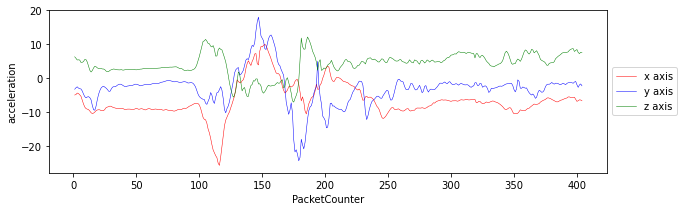

In [53]:
plt.figure(figsize=(10,3))
plt.plot(df_train['PacketCounter'], df_train['Acc_X'], linewidth=0.5, color='r', label='x axis')
plt.plot(df_train['PacketCounter'], df_train['Acc_Y'], linewidth=0.5, color='b', label='y axis')
plt.plot(df_train['PacketCounter'], df_train['Acc_Z'], linewidth=0.5, color='g', label='z axis')
plt.xlabel('PacketCounter')
plt.ylabel('acceleration')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

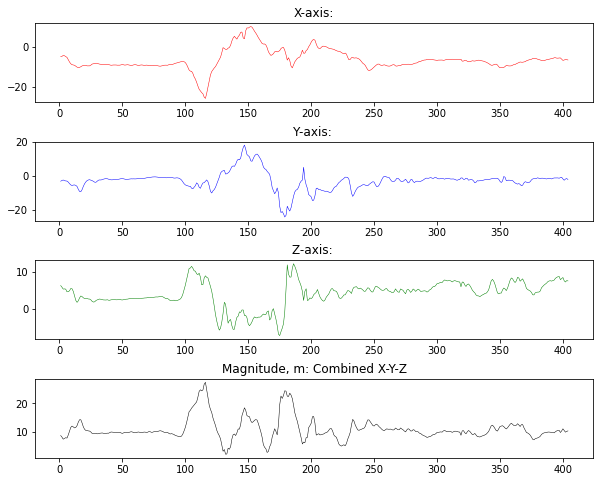

In [54]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,8))

ax[0].set_title('X-axis:')
ax[0].plot(df_train['PacketCounter'], df_train['Acc_X'], linewidth=0.5, color='r')

ax[1].set_title('Y-axis: ')
ax[1].plot(df_train['PacketCounter'], df_train['Acc_Y'], linewidth=0.5, color='b')

ax[2].set_title('Z-axis: ')
ax[2].plot(df_train['PacketCounter'], df_train['Acc_Z'], linewidth=0.5, color='g')

ax[3].set_title('Magnitude, m: Combined X-Y-Z')
ax[3].plot(df_train['PacketCounter'], df_train['m'], linewidth=0.5, color='k')

fig.subplots_adjust(hspace=.5)

In [55]:
# Separating data for each activity
train_df = pd.concat([df_train, label_train['Label']], axis=1).dropna()
columns = ['PacketCounter', 'Acc_X', 'Acc_Y', 'Acc_Z', 'm', 'Label']

wrist_on_elbow = train_df[columns][train_df.Label == 1]
waack = train_df[columns][train_df.Label == 2]
idle = train_df[columns][train_df.Label == 3]

In [56]:
wrist_on_elbow.head()

,PacketCounter,Acc_X,Acc_Y,Acc_Z,m,Label
1,1,-4.997346,-3.298741,6.276892,8.674937,1
2,2,-4.860229,-2.856503,5.838315,8.115871,1
3,3,-4.415420,-2.575201,5.332450,7.386651,1
4,4,-4.558330,-2.955828,5.380980,7.646583,1
5,5,-4.934264,-3.140786,5.319851,7.906473,1


In [57]:
waack.head()

,PacketCounter,Acc_X,Acc_Y,Acc_Z,m,Label
82,82,-9.505702,-1.052089,3.289883,10.113782,2
83,83,-9.288963,-1.122441,3.086882,9.852591,2
84,84,-9.232818,-1.257930,2.894299,9.757268,2
85,85,-9.253806,-1.289210,2.738945,9.736365,2
86,86,-9.261637,-1.220554,2.802252,9.752963,2


In [58]:
idle.head()

,PacketCounter,Acc_X,Acc_Y,Acc_Z,m,Label
251,251,-9.583763,-5.296456,5.994767,12.483517,3
252,252,-9.061045,-6.487133,6.100417,12.704350,3
253,253,-8.696379,-6.435246,5.823425,12.286239,3
254,254,-8.729246,-5.539299,5.619998,11.767240,3
255,255,-9.196158,-4.137349,5.303192,11.393456,3


#### Plot Activity Data

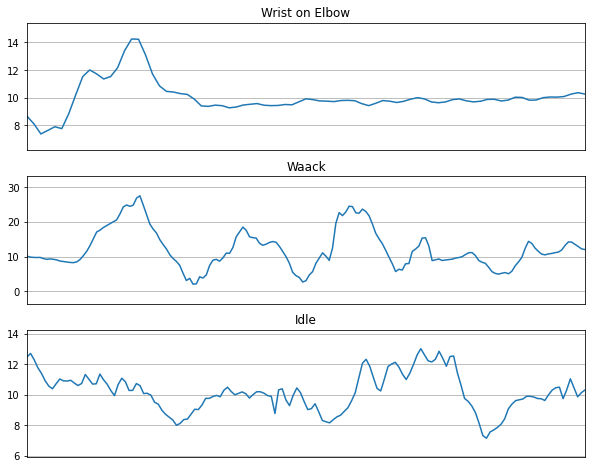

In [59]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activities, titles):
    fig, axs = plt.subplots(nrows=len(activities), figsize=(10, 8))
    for i in range(0, len(activities)):
        plot_axis(axs[i], activities[i]['PacketCounter'], activities[i]['m'], titles[i])
    plt.subplots_adjust(hspace=0.2)
    plt.show()

plot_activity([wrist_on_elbow, waack, idle],
              ['Wrist on Elbow', 'Waack', 'Idle'])

#### Split training data

In [60]:
X_train, X_test, y_train, y_test = train_test_split(train_df, label_train, test_size = 0.2, random_state = 0)

In [61]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (323, 8)
y_train shape: (323, 6)


In [62]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (81, 8)
y_test shape: (81, 6)


In [63]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = label_train['Label'].iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 300 #400 #200 #300
STEP = 150  #100 #60 #80 #40 #150

X_train, y_train = create_dataset(
    df[['Acc_X', 'Acc_Y', 'Acc_Z']], 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df[['Acc_X', 'Acc_Y', 'Acc_Z']], 
    TIME_STEPS, 
    STEP
)

In [64]:
print(X_train.shape, y_train.shape)

(254, 150, 3) (254, 1)


In [65]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [66]:
print(X_train.shape, y_train.shape)

(254, 150, 3) (254, 3)


#### Train the model

In [67]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[0], X_train.shape[1]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [68]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64, #64 #128 #32
    validation_split=0.1,
    shuffle=True
)

Train on 228 samples, validate on 26 samples
Epoch 1/20
228/228 [==============================] - 4s 16ms/sample - loss: 0.8633 - acc: 0.6009 - val_loss: 1.6525 - val_acc: 0.0000e+00
Epoch 2/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.3885 - acc: 0.8289 - val_loss: 1.2491 - val_acc: 0.2692
Epoch 3/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.2210 - acc: 0.9298 - val_loss: 1.0231 - val_acc: 0.3846
Epoch 4/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.1503 - acc: 0.9474 - val_loss: 1.6579 - val_acc: 0.3462
Epoch 5/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.0778 - acc: 0.9781 - val_loss: 3.2185 - val_acc: 0.2692
Epoch 6/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.0657 - acc: 0.9825 - val_loss: 3.3717 - val_acc: 0.3077
Epoch 7/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.0331 - acc: 0.9912 - val_loss: 1.6336 - val_acc: 0.4231
Epoch 8/20
2

#### Evaluation

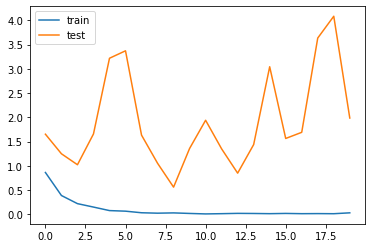

In [69]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

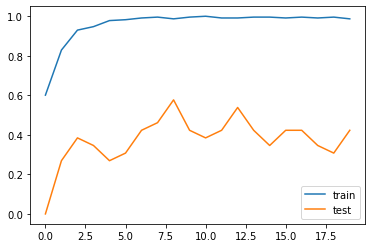

In [70]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend();

In [71]:
model.evaluate(X_test, y_test)

254/254 [==============================] - 0s 883us/sample - loss: 0.2090 - acc: 0.9409


[0.20897559954429148, 0.9409449]

In [72]:
model.evaluate(X_train, y_train)

254/254 [==============================] - 0s 931us/sample - loss: 0.2090 - acc: 0.9409


[0.20897559954429148, 0.9409449]

#### Confusion Matrix

In [73]:
y_pred = model.predict(X_test)

In [74]:
column_names = 'Wrist_on_Elbow', 'Waack', 'Idle'

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(column_names)
  ax.set_yticklabels(column_names)
  b, t = plt.ylim() # discover the values for bottom and top
  #b += 0.5 # Add 0.5 to the bottom
  #t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

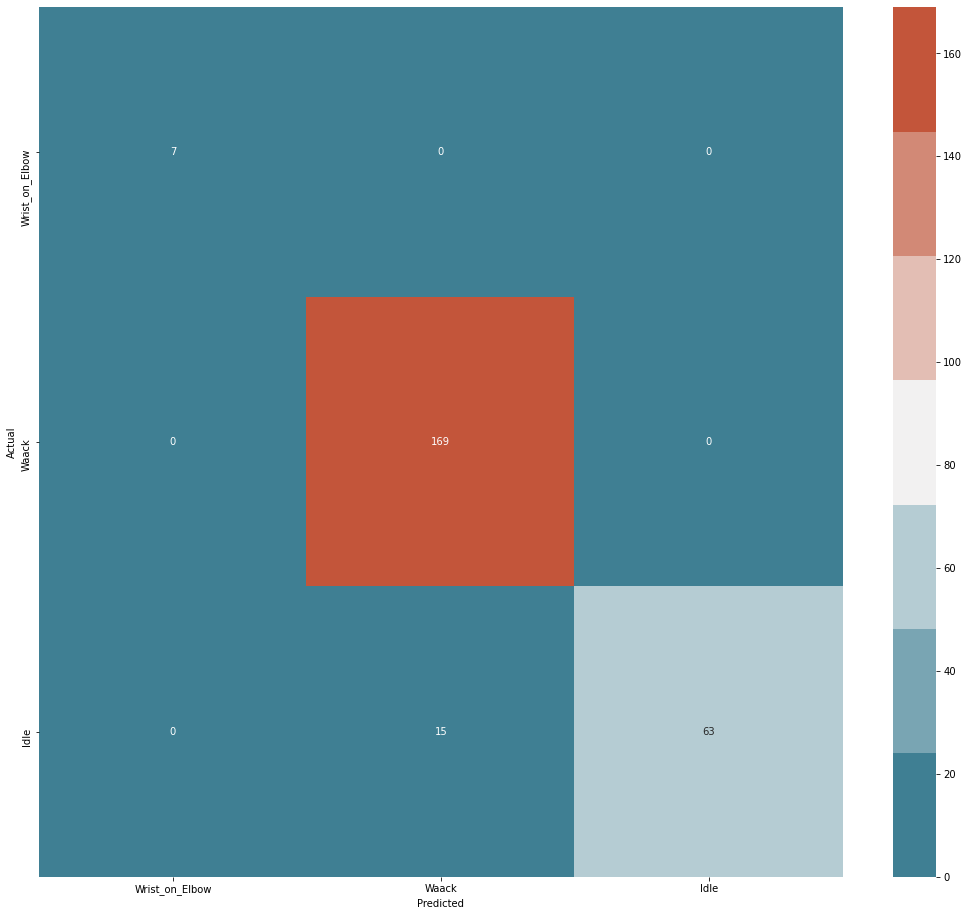

In [75]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)